In [1]:
#!pip install grakel

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pickle
import numpy as np
#from grakel import Graph, WeisfeilerLehman, VertexHistogram
from sklearn.decomposition import KernelPCA
#from grakel.kernels import WeisfeilerLehman, VertexHistogram
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import networkx as nx
from networkx.algorithms.dag import is_directed_acyclic_graph
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clrs-dataset-extraction/__results__.html
/kaggle/input/clrs-dataset-extraction/__notebook__.ipynb
/kaggle/input/clrs-dataset-extraction/__output__.json
/kaggle/input/clrs-dataset-extraction/CLRS_2000_train_test_val
/kaggle/input/clrs-dataset-extraction/custom.css
/kaggle/input/clrs-dataset-extraction/clrs_dataset/topological_sort_test/1.0.0/features.json
/kaggle/input/clrs-dataset-extraction/clrs_dataset/topological_sort_test/1.0.0/dataset_info.json
/kaggle/input/clrs-dataset-extraction/clrs_dataset/topological_sort_test/1.0.0/clrs_dataset-test.tfrecord-00000-of-00001
/kaggle/input/clrs-dataset-extraction/clrs_dataset/topological_sort_val/1.0.0/features.json
/kaggle/input/clrs-dataset-extraction/clrs_dataset/topological_sort_val/1.0.0/dataset_info.json
/kaggle/input/clrs-dataset-extraction/clrs_dataset/topological_sort_val/1.0.0/clrs_dataset-val.tfrecord-00000-of-00001
/kaggle/input/clrs-dataset-extraction/clrs_dataset/topological_sort_train/1.0.0/features.json
/kaggle/in

In [2]:
file_path = '/kaggle/input/clrs-dataset-extraction/CLRS_2000_train_test_val'

with open(file_path, 'rb') as file:
    adj_mats = pickle.load(file)

In [24]:
import numpy as np
import hashlib

def stable_hash(value):
    """ Compute a stable hash of the given value using MD5. """
    return hashlib.md5(str(value).encode()).hexdigest()

def get_WL_embedding(graph, n_iter):
    graph_hash_dict = {}
    labels = [np.sum(graph[x]) for x in range(len(graph))]  # Initialize labels based on node degrees

    for _ in range(n_iter):
        neighbor_labels = [sorted([labels[j] for j in range(len(graph)) if graph[i, j] == 1]) for i in range(len(graph))]
        hashes = np.array([stable_hash((labels[i], tuple(neighbor_labels[i]))) for i in range(len(graph))])
        
        for unique_hash in set(hashes):
            graph_hash_dict[unique_hash] = np.sum(hashes == unique_hash)

        labels = hashes.tolist()

    return graph_hash_dict

def compare_graph_embeddings(embedding1, embedding2):
    # Combine all keys and create zero-filled vectors
    all_keys = set(embedding1.keys()).union(embedding2.keys())
    vector1 = np.array([embedding1.get(key, 0) for key in all_keys])
    vector2 = np.array([embedding2.get(key, 0) for key in all_keys])

    # Example: Cosine Similarity
    cosine_similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    
    return cosine_similarity
import numpy as np

def compare_graph_dataset_embeddings(embedding1, embedding2):
    all_keys = set(embedding1.keys()).union(embedding2.keys())
    vector1 = np.array([np.mean(embedding1.get(key, [0])) for key in all_keys])
    vector2 = np.array([np.mean(embedding2.get(key, [0])) for key in all_keys])

    # Handle the case where one or both vectors are all zeros
    if np.all(vector1 == 0) or np.all(vector2 == 0):
        return 0

    # Compute Cosine Similarity
    cosine_similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    
    return cosine_similarity



def find_graph_dataset_distribution(graph_dataset):
    dataset_distro_dict = {}
    for graph in graph_dataset:
        graph_hash_dict = get_WL_embedding(graph, 3)
        for graph_hash, count in graph_hash_dict.items():
            if graph_hash not in dataset_distro_dict:
                dataset_distro_dict[graph_hash] = [count]
            else:
                dataset_distro_dict[graph_hash].append(count)
    return dataset_distro_dict
    
    

In [25]:
def make_acyclic(G):
    """
    Removes edges to make a graph G acyclic.
    """
    while not is_directed_acyclic_graph(G):
        try:
            # Identify a cycle
            cycle = nx.find_cycle(G, orientation='original')
            # Remove an edge from the cycle
            G.remove_edge(cycle[0][0], cycle[0][1])
        except nx.NetworkXNoCycle:
            break  # Break the loop if no cycle is found
    return G
def generate_ER_graph_dataset(n = 16, total = 1000):
    graph_dataset = []
    for x in range(total):
            G_er = nx.fast_gnp_random_graph(n, .3, directed=True)
            
            G_er = make_acyclic(G_er)
            G_er = nx.adjacency_matrix(G_er).todense()
            graph_dataset.append(G_er)
    return graph_dataset
def generate_Watts(n = 16, total = 1000):
    graph_dataset = []
    for x in range(total):
        G_ba = nx.barabasi_albert_graph(n, 2)
        G_ba = nx.DiGraph(G_ba)  # Convert to directed graph
        G_ba = make_acyclic(G_ba)
        G_ba = nx.adjacency_matrix(G_ba).todense()
        graph_dataset.append(G_ba)
    return graph_dataset
def generate_diverse_graph_dataset(n = 16, total = 1000):
    graph_dataset = []
    for x in range(total):
        which_graph = np.random.randint(0, 4)
        if which_graph == 0:
            G_er = nx.gnm_random_graph(n, int(n*1.5), directed=True)
            G_er = make_acyclic(G_er)
            G_er = nx.adjacency_matrix(G_er).todense()
            graph_dataset.append(G_er)
        # Watts-Strogatz (need to modify for DAG)
        elif which_graph == 1:
            G_ws = nx.watts_strogatz_graph(n, 4, 0.5)
            G_ws = nx.DiGraph(G_ws)  # Convert to directed graph
            G_ws = make_acyclic(G_ws)
            G_ws = nx.adjacency_matrix(G_ws).todense()
            graph_dataset.append(G_ws)
        # Barabasi-Albert (need to modify for DAG)
        elif which_graph == 2:
            G_ba = nx.barabasi_albert_graph(n, 2)
            G_ba = nx.DiGraph(G_ba)  # Convert to directed graph
            G_ba = make_acyclic(G_ba)
            G_ba = nx.adjacency_matrix(G_ba).todense()
            graph_dataset.append(G_ba)
        # Stochastic Block Model
        else:
            # Ensure the number of blocks is a power of 2 and divides 'n' evenly
            num_blocks = 2**np.random.randint(1, int(math.log2(n)) + 1)
            block_size = n // num_blocks
            sizes = [block_size] * num_blocks  # Equal-sized blocks
            
            # Generating a random p_matrix
            p_matrix = np.random.rand(num_blocks, num_blocks) / 20
            
            G_sbm = nx.stochastic_block_model(sizes, p_matrix.tolist(), directed=True)
            G_sbm = make_acyclic(G_sbm)
            G_sbm = nx.to_numpy_array(G_sbm)
            graph_dataset.append(G_sbm)
    return graph_dataset
        

In [26]:
def DAG_ER_generator(num_graphs = 500, num_nodes = 16, edge_prob = .5):
    if not 0 <= edge_prob <= 1:
        raise ValueError('Improper probability')
    if num_graphs < 1 or num_nodes < 1:
        raise ValueError('Graphs and nodes must be greater than 1')
    random_matrices = np.random.random((int(num_graphs), int(num_nodes), int(num_nodes)))
    upper_tri_mask = np.triu(np.ones((num_nodes, num_nodes), dtype=bool), k=1)
    G = random_matrices < edge_prob
    G = np.logical_and(G, upper_tri_mask[np.newaxis, :, :])
    return G

def DAG_DBA_generator(num_graphs = 500, num_nodes = 16, num_p_edges = 3, num_p_minus_one_edges = 1, edge_prob = .5):
    if not 0 < edge_prob < 1:
        raise ValueError('Improper probability')
    if num_graphs < 1 or num_nodes < 1:
        raise ValueError('Graphs and nodes must be greater than 1')
    size_of_first_star = max(num_p_edges, num_p_minus_one_edges)
    if size_of_first_star > num_nodes - 1:
        raise ValueError('num_p_edges and num_p_minus_one_edges must be less than num_nodes')

    graphs = np.zeros(shape=(num_graphs, num_nodes, num_nodes), dtype=bool)
    
    for idx in range(num_graphs):
        G = np.zeros((num_nodes, num_nodes), dtype=bool)
        # Initial active node(s) with out-edges
        G[0, 1:size_of_first_star] = True  # Assuming nodes 0 to size_of_first_star-1 can initially point to node 0
        
        for target in range(size_of_first_star, num_nodes):
            potential_sources = np.arange(target)
            out_degrees = G[:target, :].sum(axis=1)  # Sum over rows to get out-degrees
            probs = (out_degrees + 1) / (out_degrees + 1).sum()
            m = num_p_edges if np.random.random() < edge_prob else num_p_minus_one_edges
            sources = np.random.choice(potential_sources, size=m, replace=False, p=probs)
            G[sources, target] = True

        graphs[idx] = G
    
    return graphs
            

def rich_get_richer_DAG(num_graphs=500, num_nodes=16, star_size=3, max_edges=5, num_starting_stars=3, edge_prob=0.5):
    num_pendants = star_size - 1
    if not 0 < edge_prob < 1:
        raise ValueError('Improper probability')
    if num_graphs < 1 or num_nodes < 1:
        raise ValueError('Graphs and nodes must be greater than 1')
    if not 1 <= num_starting_stars * star_size < num_nodes:
        raise ValueError('Number of stars needs to be greater than one and num_stars * star_size cannot exceed graph size')

    graphs = np.zeros(shape=(num_graphs, num_nodes, num_nodes), dtype=bool)
    
    for idx in range(num_graphs):
        G = np.zeros((num_nodes, num_nodes), dtype=bool)
        last_pendant = -1
        # Initial active node(s) with out-edges
        for star_index in range(num_starting_stars):
            pendant_start = num_starting_stars + star_index * (num_pendants)
            pendant_stop = pendant_start + num_pendants
            G[star_index, pendant_start:pendant_stop] = True  # Corrected indices
            last_pendant = pendant_stop
        
        # Ensure graph growth starts correctly after initializing stars
        for target in range(last_pendant + 1, num_nodes):
            potential_sources = np.arange(target)
            out_degrees = np.sum(G[:target], axis=1)  # Sum over rows to get out-degrees
            probs = (out_degrees + 1) / np.sum(out_degrees + 1)
            m = np.random.randint(1, max_edges + 1) if np.random.random() < edge_prob else 1
            sources = np.random.choice(potential_sources, size=m, replace=True, p=probs)
            G[sources, target] = True
        graphs[idx] = G
    
    return graphs

In [27]:
diverse_16_node_graphs =  rich_get_richer_DAG()
diverse_64_node_graphs = rich_get_richer_DAG(num_nodes = 64)
diverse_128_node_graphs = rich_get_richer_DAG(num_nodes = 128)


In [28]:
ER_16_node_graphs = DAG_ER_generator()
ER_64_node_graphs = DAG_ER_generator(num_nodes = 64)
ER_128_node_graphs = DAG_ER_generator(num_nodes = 128)

In [29]:
dataset_distro_dict_train_1 = find_graph_dataset_distribution(ER_16_node_graphs)
dataset_distro_dict_train_2 = find_graph_dataset_distribution(ER_64_node_graphs)
dataset_distro_dict_test = find_graph_dataset_distribution(ER_128_node_graphs)
diverse_distro_dict_train_1 = find_graph_dataset_distribution(diverse_16_node_graphs)
diverse_distro_dict_train_2 = find_graph_dataset_distribution(diverse_64_node_graphs)
diverse_distro_dict_test = find_graph_dataset_distribution(diverse_128_node_graphs)

In [30]:
cosine_similarity_dict = {}
datasets = {'Erdős-Rényi (16 nodes)': dataset_distro_dict_train_1, 
            'Erdős-Rényi (64 nodes)': dataset_distro_dict_train_2, 
            'Erdős-Rényi (128 nodes)': dataset_distro_dict_test, 
            'Diverse Models (16 nodes)': diverse_distro_dict_train_1, 
            'Diverse Models (64 nodes)': diverse_distro_dict_train_2, 
            'Diverse Models (128 nodes)': diverse_distro_dict_test}
for xk, xv in datasets.items():
    cosine_similarity_dict[xk] = {}
    for yk, yv in datasets.items():
        cosine_similarity_dict[xk][yk] = compare_graph_dataset_embeddings(xv, yv)
    

In [31]:
cosine_similarity_df = pd.DataFrame(cosine_similarity_dict)
cosine_similarity_df

,Erdős-Rényi (16 nodes),Erdős-Rényi (64 nodes),Erdős-Rényi (128 nodes),Diverse Models (16 nodes),Diverse Models (64 nodes),Diverse Models (128 nodes)
Erdős-Rényi (16 nodes),1.000000,0.052319,0.035761,0.131228,0.079362,0.071337
Erdős-Rényi (64 nodes),0.052319,1.000000,0.014365,0.045793,0.029596,0.025954
Erdős-Rényi (128 nodes),0.035761,0.014365,1.000000,0.032140,0.020044,0.017802
Diverse Models (16 nodes),0.131228,0.045793,0.032140,1.000000,0.438306,0.481735
Diverse Models (64 nodes),0.079362,0.029596,0.020044,0.438306,1.000000,0.462143
Diverse Models (128 nodes),0.071337,0.025954,0.017802,0.481735,0.462143,1.000000


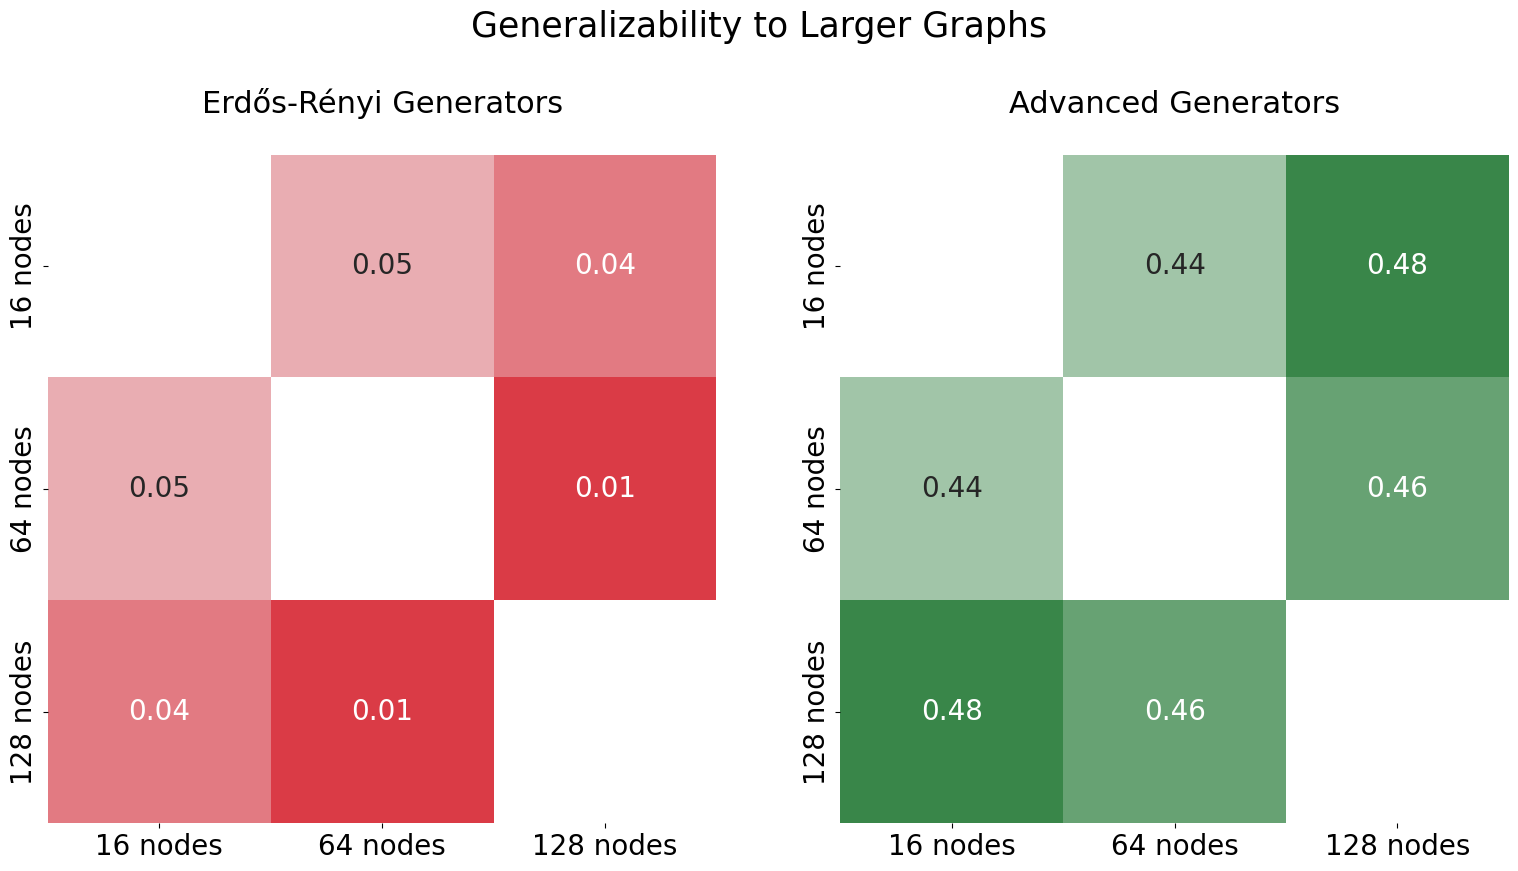

In [112]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data setup
first_three = cosine_similarity_df.iloc[0:3, 0:3]
last_three = cosine_similarity_df.iloc[-3:, -3:]

# Custom color map setup
cmap = sns.diverging_palette(10, 133, sep=20, as_cmap=True)  # Adjusts the color palette
center_val = 0.25

# Create a figure to hold the subplots
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed

# First subplot for the first three rows and columns
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
mask_first_three = np.zeros_like(first_three, dtype=bool)
np.fill_diagonal(mask_first_three, True)
ax1 = sns.heatmap(first_three, annot=True, cmap=cmap, mask=mask_first_three, center=.08, fmt=".2f", square=True, annot_kws={'size': 20}, cbar=False)
ax1.set_title('Erdős-Rényi Generators\n', fontsize=22)
tick_labels_first = ['16 nodes','64 nodes', '128 nodes']
ax1.set_xticklabels(tick_labels_first, rotation=0,  fontsize=20)
ax1.set_yticklabels(tick_labels_first, rotation=90, fontsize=20)

# Second subplot for the last three rows and columns
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
mask_last_three = np.zeros_like(last_three, dtype=bool)
np.fill_diagonal(mask_last_three, True)
ax2 = sns.heatmap(last_three, annot=True, cmap=cmap, mask=mask_last_three, center=.4, fmt=".2f", square=True, annot_kws={'size': 20}, cbar=False)
ax2.set_title('Advanced Generators\n', fontsize=22)
tick_labels_last = ['16 nodes','64 nodes', '128 nodes']
ax2.set_xticklabels(tick_labels_last, rotation=0, fontsize=20)
ax2.set_yticklabels(tick_labels_last, rotation=90, fontsize=20)

plt.suptitle("Generalizability to Larger Graphs", fontsize=25, y=1.05)
# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


ER_16_train_1 = find_graph_dataset_distribution(generate_ER_graph_dataset(n = 256, total = 50))
ER_16_train_2 = find_graph_dataset_distribution(generate_ER_graph_dataset(n = 256, total = 50))
ER_16_train_3 = find_graph_dataset_distribution(generate_ER_graph_dataset(n = 256, total = 50))
ER_16_train_4 = find_graph_dataset_distribution(generate_ER_graph_dataset(n = 256, total = 50))
ER_16_train_5 = find_graph_dataset_distribution(generate_ER_graph_dataset(n = 256, total = 50))
DV_16_train_1 = find_graph_dataset_distribution(generate_diverse_graph_dataset(n = 256, total = 50))
DV_16_train_2 = find_graph_dataset_distribution(generate_diverse_graph_dataset(n = 256, total = 50))
DV_16_train_3 = find_graph_dataset_distribution(generate_diverse_graph_dataset(n = 256, total = 50))
DV_16_train_4 = find_graph_dataset_distribution(generate_diverse_graph_dataset(n = 256, total = 50))
DV_16_train_5 = find_graph_dataset_distribution(generate_diverse_graph_dataset(n = 256, total = 50))

ER_similarity_dict = {}
ER_datasets = {'Erdős-Rényi Dataset 1': ER_16_train_1, 
            'Erdős-Rényi Dataset 2': ER_16_train_2,
            'Erdős-Rényi Dataset 3': ER_16_train_3,
            'Erdős-Rényi Dataset 4': ER_16_train_4, 
            'Erdős-Rényi Dataset 5': ER_16_train_5}
for xk, xv in ER_datasets.items():
    ER_similarity_dict[xk] = {}
    for yk, yv in ER_datasets.items():
        ER_similarity_dict[xk][yk] = compare_graph_dataset_embeddings(xv, yv)

ER_cosine_similarity_df = pd.DataFrame(ER_similarity_dict)

mask = np.zeros_like(ER_cosine_similarity_df, dtype=bool)
np.fill_diagonal(mask, True)
# Setting up a custom color map
cmap = sns.diverging_palette(133, 10, sep = 20, as_cmap=True)  # This gives a green to red diverging color palette
center_val = 0.7335
# Generate the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ER_cosine_similarity_df, annot=True, cmap=cmap, mask = mask, center = center_val, fmt=".4f", square=True)
plt.title('Similarity of 5 Randomly Generated Erdős-Rényi Graph Datasets')

# Adjusting the tick labels
tick_labels = ER_cosine_similarity_df.columns.values
ax.set_xticklabels(tick_labels, rotation=45, ha="right")
ax.set_yticklabels(tick_labels, rotation=0)
plt.show()

DV_similarity_dict = {}
DV_datasets = {'Diverse Dataset 1': DV_16_train_1, 
            'Diverse Dataset 2': DV_16_train_2,
            'Diverse Dataset 3': DV_16_train_3,
            'Diverse Dataset 4': DV_16_train_4, 
            'Diverse Dataset 5': DV_16_train_5}
for xk, xv in DV_datasets.items():
    DV_similarity_dict[xk] = {}
    for yk, yv in DV_datasets.items():
        DV_similarity_dict[xk][yk] = compare_graph_dataset_embeddings(xv, yv)
DV_cosine_similarity_df = pd.DataFrame(DV_similarity_dict)

mask = np.zeros_like(DV_cosine_similarity_df, dtype=bool)
np.fill_diagonal(mask, True)
# Setting up a custom color map
cmap = sns.diverging_palette(133, 10, sep = 20, as_cmap=True)  # This gives a green to red diverging color palette
center_val = 0.7335
# Generate the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(DV_cosine_similarity_df, annot=True, cmap=cmap, mask = mask, center = center_val, fmt=".4f", square=True)
plt.title('Similarity of 5 Randomly Generated Graph Datasets Using Diverse Models')


# Adjusting the tick labels
tick_labels = DV_cosine_similarity_df.columns.values
ax.set_xticklabels(tick_labels, rotation=45, ha="right")
ax.set_yticklabels(tick_labels, rotation=0)
plt.show()

In [6]:
hooker_3 = np.load('/kaggle/input/kernel-embedding/hooker_3.npy')

In [10]:
ER_16 = find_graph_dataset_distribution(DAG_ER_generator())
Price_16 = find_graph_dataset_distribution(DAG_DBA_generator())
Multi_price_16 = find_graph_dataset_distribution(rich_get_richer_DAG())
ER_32 = find_graph_dataset_distribution(DAG_ER_generator(num_nodes = 32))
Price_32 = find_graph_dataset_distribution(DAG_DBA_generator(num_nodes = 32))
Multi_price_32 = find_graph_dataset_distribution(rich_get_richer_DAG(num_nodes = 32))

In [22]:


cosine_similarity_dict_rw = {}
datasets = {'Erdős-Rényi Generator\n16 Nodes': ER_16, 
            'Advanced Generator 1\n16 nodes': Price_16, 
            'Advanced Generator 2\n16 nodes': Multi_price_16, 
            'Erdős-Rényi Generator\n32 Nodes': ER_32, 
            'Advanced Generator 1\n32 nodes': Price_32, 
            'Advanced Generator 2\n32 nodes': Multi_price_32}

multiple = 90
hooker_dict = {}
for i in range(6):
    hooker_dict[f'Real-World Dataset {i+1}'] = get_WL_embedding(hooker_3[i*multiple:(i+1)*multiple], 3)
for xk, xv in datasets.items():
    cosine_similarity_dict_rw[xk] = {}
    for yk, yv in hooker_dict.items():
        cosine_similarity_dict_rw[xk][yk] = compare_graph_dataset_embeddings(xv, yv)
cosine_similarity_df_rw = pd.DataFrame(cosine_similarity_dict_rw)


In [89]:
cosine_similarity_df_rw

,Erdős-Rényi Generator\n16 Nodes,Advanced Generator 1\n16 nodes,Advanced Generator 2\n16 nodes,Erdős-Rényi Generator\n32 Nodes,Advanced Generator 1\n32 nodes,Advanced Generator 2\n32 nodes
Real-World Dataset 1,0.035474,0.240794,0.570267,0.020181,0.361214,0.417692
Real-World Dataset 2,0.029419,0.211585,0.501131,0.016712,0.320096,0.369262
Real-World Dataset 3,0.032122,0.233095,0.552084,0.018232,0.353023,0.407191
Real-World Dataset 4,0.032222,0.233815,0.553791,0.018288,0.354114,0.408450
Real-World Dataset 5,0.032143,0.233243,0.552436,0.018243,0.353248,0.407451
Real-World Dataset 6,0.032005,0.232244,0.550071,0.018165,0.351735,0.405706


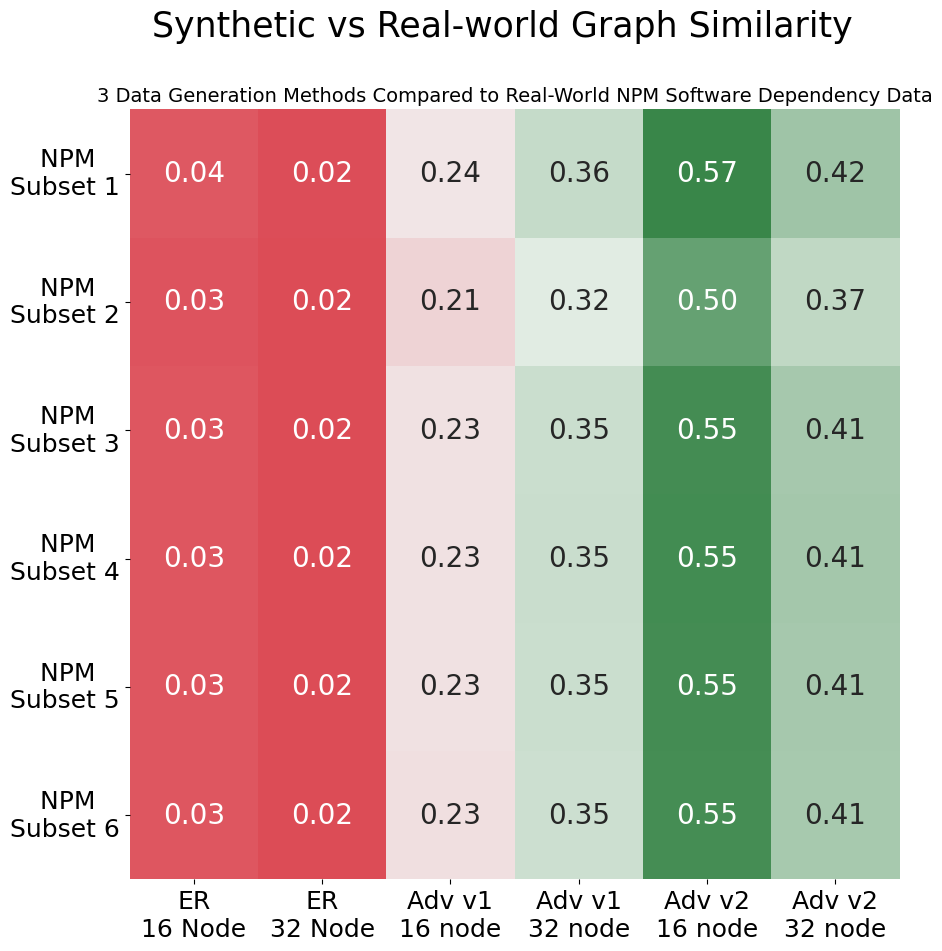

In [121]:
mask = np.zeros_like(cosine_similarity_df_rw, dtype=bool)
np.fill_diagonal(mask, True)
# Setting up a custom color map
cmap = sns.diverging_palette(10, 133, sep = 20, as_cmap=True)  # This gives a green to red diverging color palette
center_val = 0.28
# Generate the heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cosine_similarity_df_rw.iloc[:, [0,3,1,4,2,5]], annot=True, cmap=cmap,  center = center_val, fmt=".2f", square=True, annot_kws = {"size": 20}, cbar = False)
plt.suptitle('Synthetic vs Real-world Graph Similarity', fontsize=25)
plt.title("3 Data Generation Methods Compared to Real-World NPM Software Dependency Data", fontsize = 14)

# Adjusting the tick labels
tick_labels = ['ER\n16 Node', 'ER\n32 Node','Adv v1\n16 node', 'Adv v1\n32 node','Adv v2\n16 node',   'Adv v2\n32 node']
y_tick_labels = ['NPM   \nSubset 1', 'NPM   \nSubset 2', 'NPM   \nSubset 3', 'NPM   \nSubset 4', 'NPM   \nSubset 5', 'NPM   \nSubset 6']
ax.set_xticklabels(tick_labels, rotation=0,  fontsize = 18)
ax.set_yticklabels(y_tick_labels, rotation=0, fontsize = 18)
plt.show()

In [ ]:
get_WL_